# TER EDA

In [1]:
# built-in imports
import sys
import os
# src imports
module_path = os.path.abspath(os.path.join('..', '..')) 
sys.path.insert(0, module_path)
from src.utils import load_emorynlp, load_isear, filter_emotions, load_iemocap
# third-party imports 
import numpy as np
import pandas as pd

# load datasets
emory = filter_emotions(load_emorynlp())
isear = filter_emotions(load_isear())

# add a dataset column to each dataset
emory['dataset'] = 'emorynlp'
isear['dataset'] = 'isear'

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 77 episodes from EmoryNLP train dataset
Loaded 7102 samples from ISEAR dataset


In [4]:
isear.label.value_counts()

label
fear     2252
angry    1701
happy    1616
sad      1533
Name: count, dtype: int64

In [5]:
emory.label.value_counts()

label
neutral    3034
happy      2184
fear       1285
sad         671
Name: count, dtype: int64

In [6]:
#!pip install wordcloud

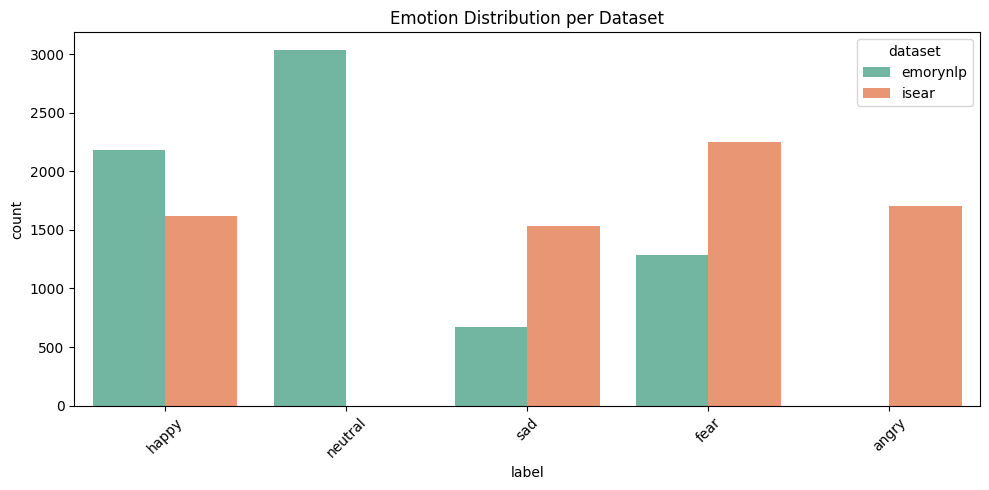

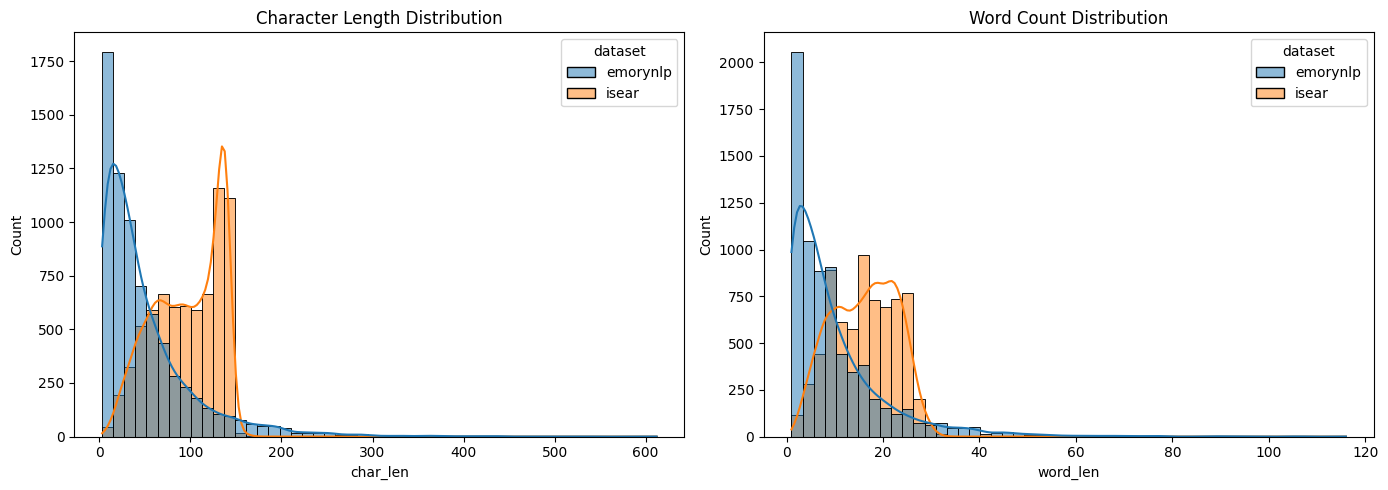

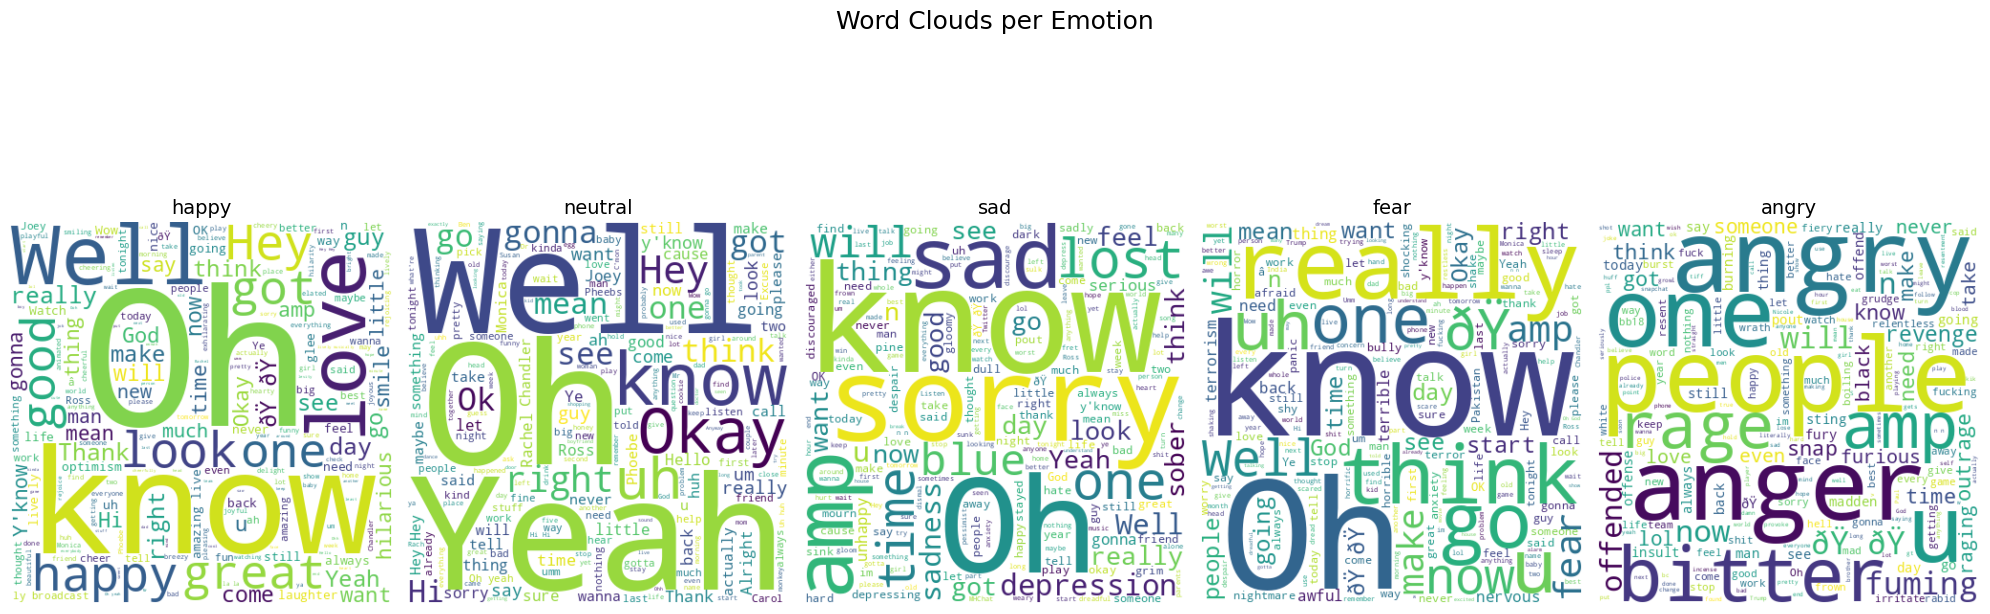

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Combine for joint analysis
df = pd.concat([emory, isear], ignore_index=True)

# ------------------------------------------------
# 1. Label distribution
# ------------------------------------------------
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="label", hue="dataset", palette="Set2")
plt.title("Emotion Distribution per Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 2. Text length analysis
# ------------------------------------------------
df["char_len"] = df["text"].apply(len)
df["word_len"] = df["text"].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(data=df, x="char_len", hue="dataset", bins=50, kde=True, ax=axes[0])
axes[0].set_title("Character Length Distribution")

sns.histplot(data=df, x="word_len", hue="dataset", bins=50, kde=True, ax=axes[1])
axes[1].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3. Word clouds per emotion
# ------------------------------------------------
emotions = df["label"].unique()
fig, axes = plt.subplots(1, len(emotions), figsize=(20,8))

for i, emotion in enumerate(emotions):
    text_data = " ".join(df[df["label"] == emotion]["text"])
    wc = WordCloud(width=400, height=400, background_color="white").generate(text_data)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(emotion, fontsize=14)
    axes[i].axis("off")

plt.suptitle("Word Clouds per Emotion", fontsize=18)
plt.tight_layout()
plt.show()



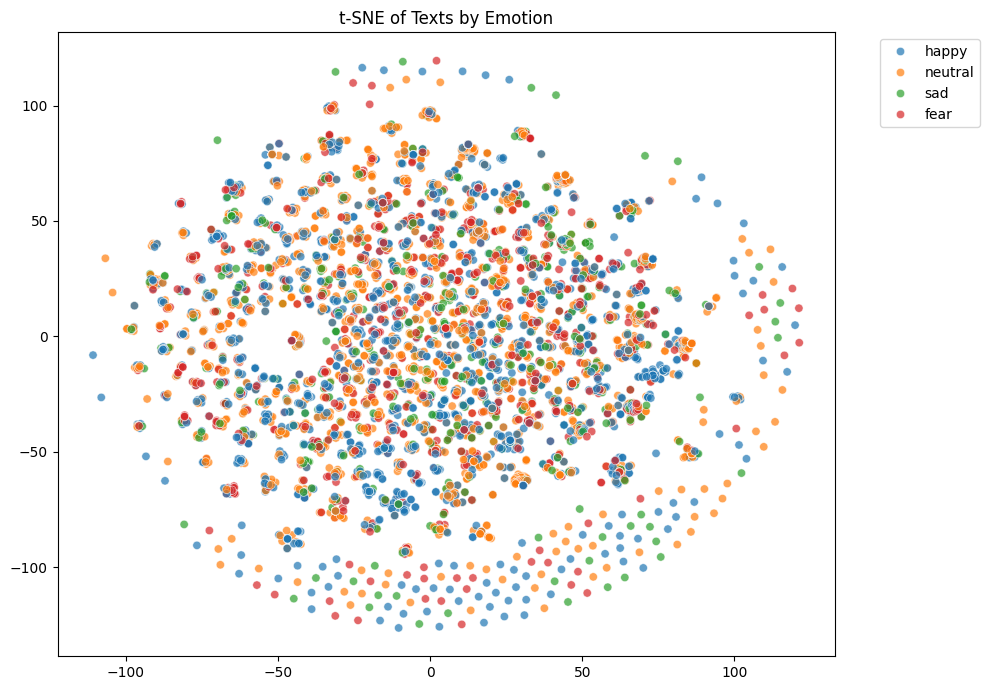

In [16]:
# ------------------------------------------------
# 4. t-SNE visualization (with TF-IDF embeddings)
# ------------------------------------------------
df1,df2 = emory, isear
# Vectorize text
vectorizer = TfidfVectorizer(max_features=300, stop_words="english")
X = vectorizer.fit_transform(df["text"])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df["label"])

# Run t-SNE (can take a few mins for large data)
tsne = TSNE(n_components=2, random_state=42, perplexity=15, learning_rate="auto")
X_embedded = tsne.fit_transform(X.toarray())

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df["label"], palette="tab10", alpha=0.7)
plt.title("t-SNE of Texts by Emotion")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/0s/lm29041s6hv5pq_lc3jblq540000gn/T/ipykernel_46830/3512714448.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")


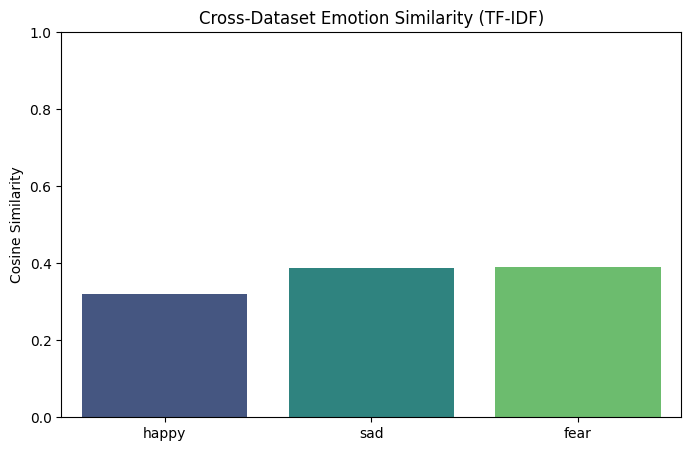

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------------------
# 5. Cross-dataset similarity per emotion
# ------------------------------------------------

vectorizer = TfidfVectorizer(max_features=300, stop_words="english") #3000

similarities = {}

df1 = emory
df2 = isear

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Combine for consistent vectorization
        combined = texts1 + texts2
        X = vectorizer.fit_transform(combined)

        # Split back into dataset parts
        X1 = X[:len(texts1)]
        X2 = X[len(texts1):]

        # Compute average embeddings per dataset
        mean1 = np.asarray(X1.mean(axis=0))
        mean2 = np.asarray(X2.mean(axis=0))

        # Cosine similarity
        sim = cosine_similarity(mean1, mean2)[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (TF-IDF)")
plt.show()


## IEMOCAP and MELD dataset

In [1]:
# built-in imports
import sys
import os
# src imports
module_path = os.path.abspath(os.path.join('..', '..')) 
sys.path.insert(0, module_path)
from src.data_loading import filter_emotions, load_meld, load_iemocap

meld_train = filter_emotions(load_meld(split='train'))
meld_test = filter_emotions(load_meld(split='test'))
iemocap = filter_emotions(load_iemocap())

meld_test['text'], meld_train['text'], iemocap['text'] = meld_test['Utterance'], meld_train['Utterance'], iemocap['transcription']
meld_train['dataset'], meld_test['dataset'], iemocap['dataset'] = 'MELD_train', 'MELD_test', 'IEMOCAP'

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia956_utt14.mp4', 'dia1032_utt1.mp4', 'dia47_utt9.mp4', 'dia645_utt11.mp4', 'dia572_utt20.mp4', 'dia457_utt2.mp4', 'dia969_utt0.mp4', 'dia232_utt4.mp4', 'dia940_utt7.mp4', 'dia619_utt5.mp4', 'dia1033_utt1.mp4', 'dia46_utt9.mp4', 'dia456_utt2.mp4', 'dia34_utt2.mp4', 'dia630_utt2.mp4', 'dia424_utt9.mp4', 'dia941_utt7.mp4', 'dia288_utt16.mp4', 'dia968_utt0.mp4', 'dia351_utt14.mp4', 'dia752_utt6.mp4', 'dia351_utt0.mp4', 'dia823_utt3.mp4', 'dia851_utt8.mp4', 'dia810_utt14.mp4', 'dia137_utt0.mp4', 'dia379_utt7.mp4', 'dia136_utt0.mp4', 'dia822_utt3.mp4', 'dia350_utt0.mp4', 'dia206_utt6.mp4', 'dia782_utt5.mp4', 'dia1006_utt3.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia463_utt0.mp4', 'dia605_utt0.mp4', 'dia334_utt10.mp4', 'dia933_utt10.mp4', 'dia783_utt5.mp4', 'dia975_utt5.mp4', 'dia207_utt6.mp4', 'dia823_utt12.mp4', 'dia604_utt0.mp4', 'dia29_utt7.mp4', 'dia380_utt3.mp4',

In [5]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven’t yet
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

print(len(stop_words))

198


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krazmic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


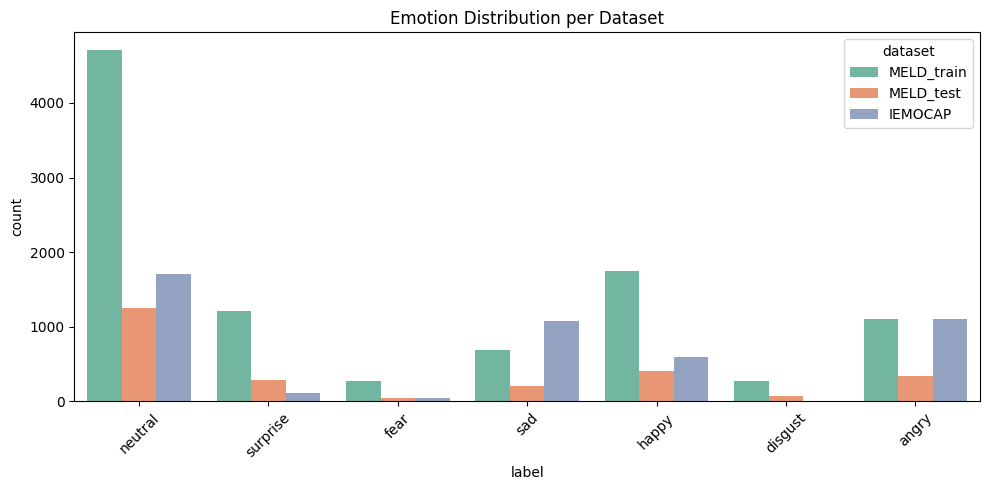

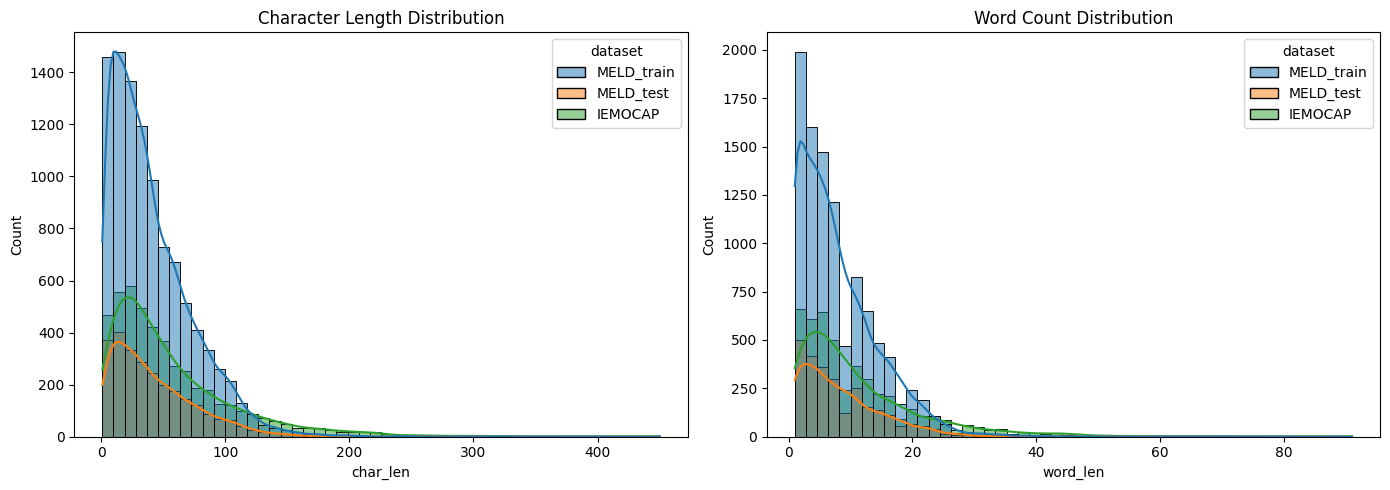

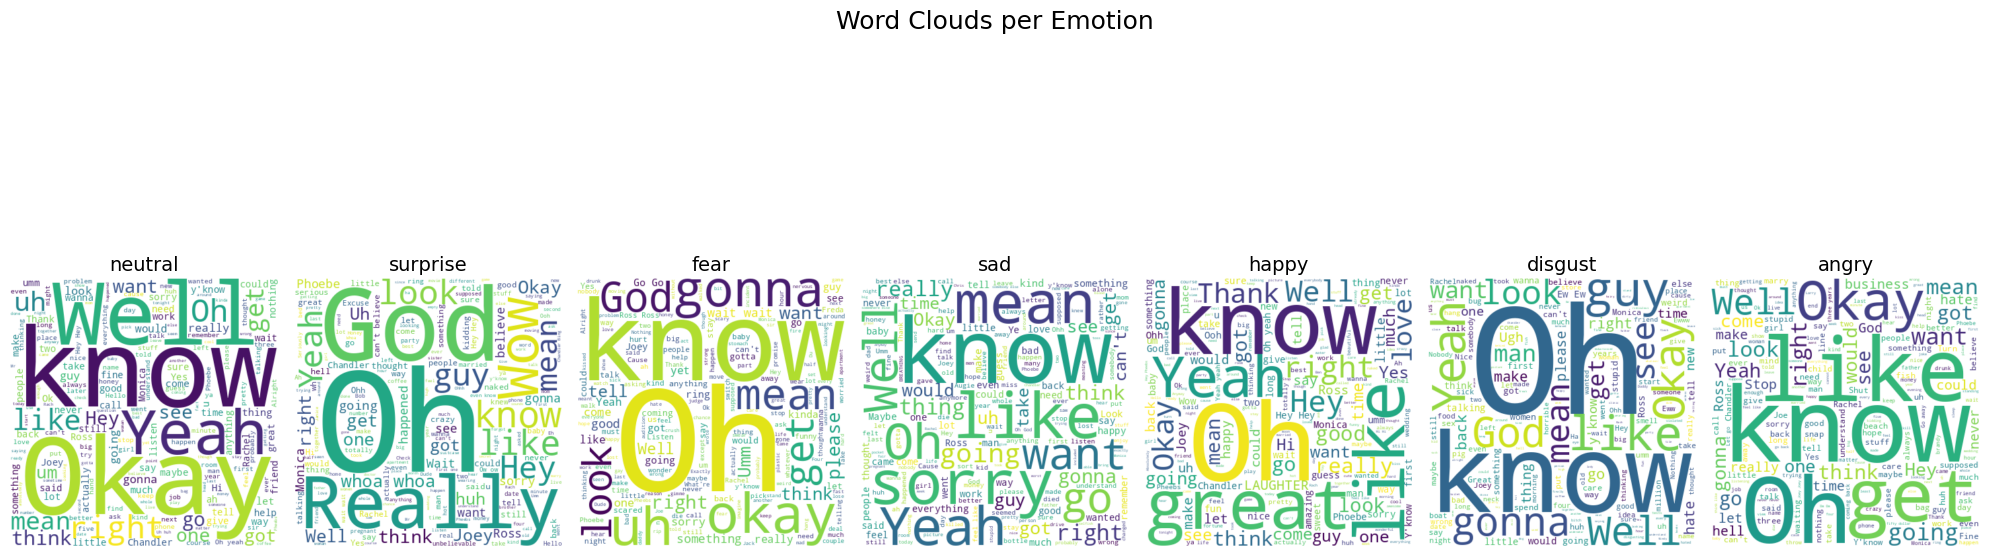

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Combine for joint analysis
df = pd.concat([meld_train, meld_test, iemocap], ignore_index=True)

# ------------------------------------------------
# 1. Label distribution
# ------------------------------------------------
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="label", hue="dataset", palette="Set2")
plt.title("Emotion Distribution per Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 2. Text length analysis
# ------------------------------------------------
df["char_len"] = df["text"].apply(len)
df["word_len"] = df["text"].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(data=df, x="char_len", hue="dataset", bins=50, kde=True, ax=axes[0])
axes[0].set_title("Character Length Distribution")

sns.histplot(data=df, x="word_len", hue="dataset", bins=50, kde=True, ax=axes[1])
axes[1].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3. Word clouds per emotion
# ------------------------------------------------
emotions = df["label"].unique()
fig, axes = plt.subplots(1, len(emotions), figsize=(20,8))

#sw = set(['s', 't', 'you', 'I', 'it', 'that', 'the', 'and'])
sw = set(stop_words)
for i, emotion in enumerate(emotions):
    text_data = " ".join(df[df["label"] == emotion]["text"])
    wc = WordCloud(width=400, height=400, background_color="white", stopwords=sw).generate(text_data)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(emotion, fontsize=14)
    axes[i].axis("off")

plt.suptitle("Word Clouds per Emotion", fontsize=18)
plt.tight_layout()
plt.show()



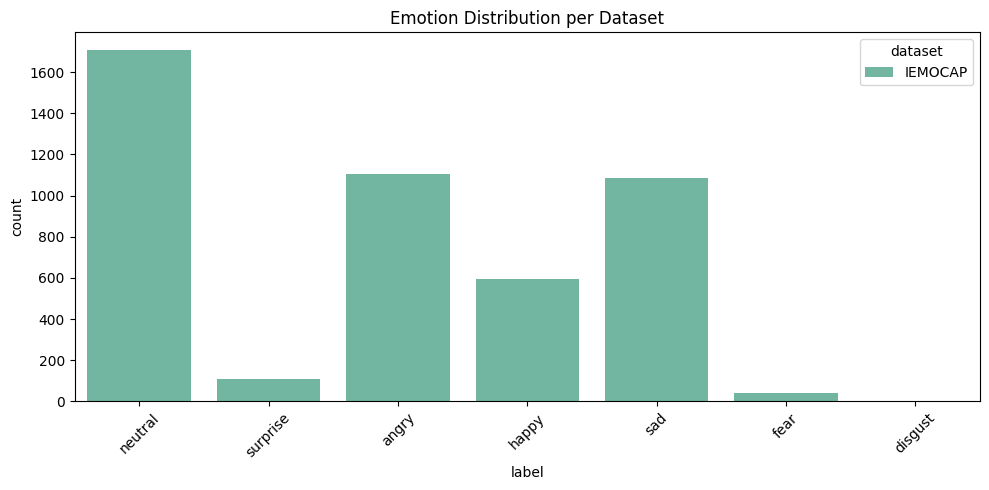

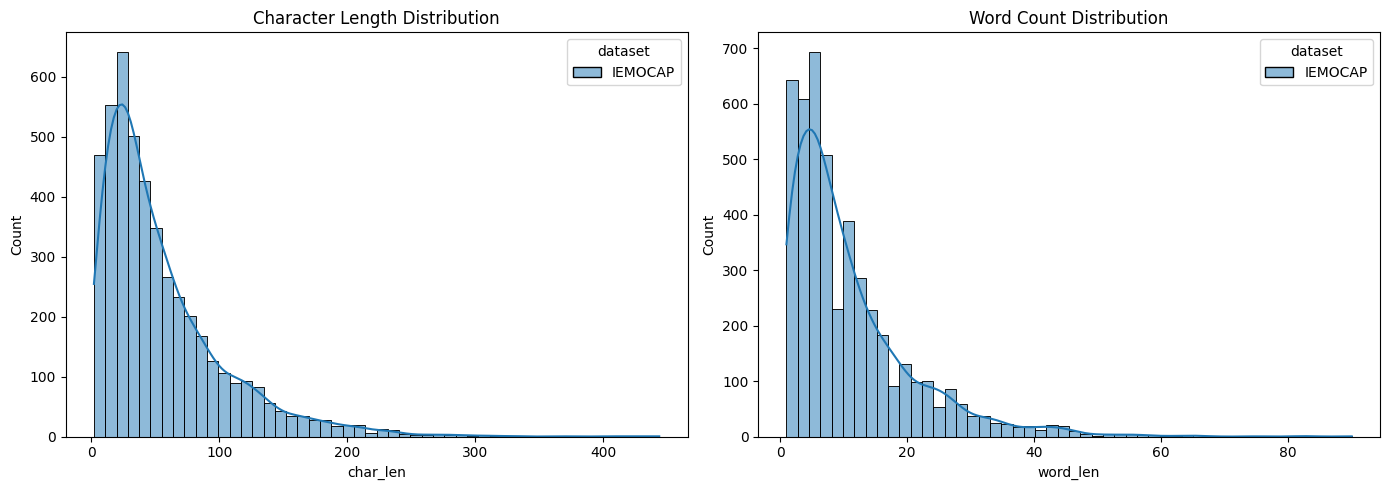

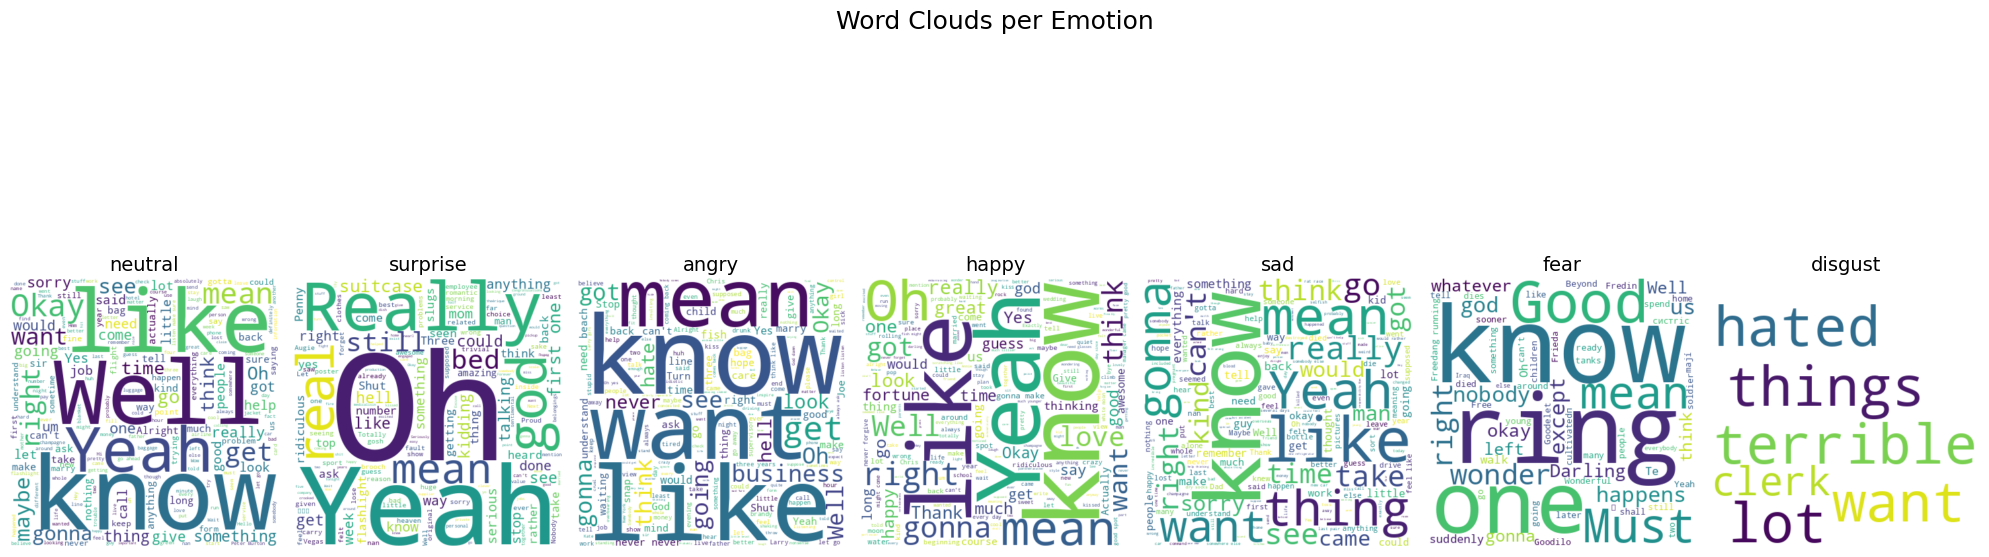

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Combine for joint analysis
df = iemocap

# ------------------------------------------------
# 1. Label distribution
# ------------------------------------------------
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="label", hue="dataset", palette="Set2")
plt.title("Emotion Distribution per Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 2. Text length analysis
# ------------------------------------------------
df["char_len"] = df["text"].apply(lambda x: len(str(x)))
df["word_len"] = df["text"].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(data=df, x="char_len", hue="dataset", bins=50, kde=True, ax=axes[0])
axes[0].set_title("Character Length Distribution")

sns.histplot(data=df, x="word_len", hue="dataset", bins=50, kde=True, ax=axes[1])
axes[1].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3. Word clouds per emotion
# ------------------------------------------------
emotions = df["label"].unique()
fig, axes = plt.subplots(1, len(emotions), figsize=(20,8))

for i, emotion in enumerate(emotions):
    text_data = " ".join([str(i) for i in df[df["label"] == emotion]["text"]])
    wc = WordCloud(width=400, height=400, background_color="white", stopwords=sw).generate(text_data)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(emotion, fontsize=14)
    axes[i].axis("off")

plt.suptitle("Word Clouds per Emotion", fontsize=18)
plt.tight_layout()
plt.show()



In [27]:
!pip install fasttext

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-macosx_15_0_arm64.whl size=325385 sha256=fb9e933f99d43a956a99b25e50d06a6c7b465acff8c01ef9f1230a5baf89f70f
  Stored in directory: /Users/krazmic/Library/Caches/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fasttext]


## Dataset cross similarity

In [29]:
df1, df2 = isear, emory

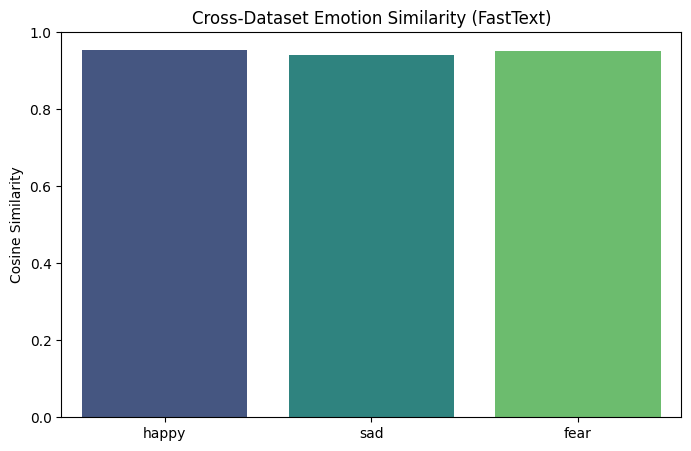

In [31]:
import fasttext.util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# Load pretrained FastText (English)
# ------------------------------------------------
fasttext.util.download_model('en', if_exists='ignore')  # downloads cc.en.300.bin
ft = fasttext.load_model('cc.en.300.bin')

def sentence_embedding(text, model):
    """Compute average FastText embedding for a sentence."""
    words = text.split()
    if not words:
        return np.zeros(model.get_dimension())
    vectors = [model.get_word_vector(w) for w in words]
    return np.mean(vectors, axis=0)

# ------------------------------------------------
# 5. Cross-dataset similarity per emotion (FastText)
# ------------------------------------------------
similarities = {}

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Average embedding per dataset
        emb1 = np.mean([sentence_embedding(t, ft) for t in texts1], axis=0)
        emb2 = np.mean([sentence_embedding(t, ft) for t in texts2], axis=0)

        # Cosine similarity
        sim = cosine_similarity([emb1], [emb2])[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (FastText)")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# Load pretrained GloVe
# ------------------------------------------------
def load_glove_embeddings(glove_path="glove.6B.300d.txt"):
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.300d.txt")  # make sure you download it first
dim = 300

def sentence_embedding_glove(text, embeddings, dim=300):
    words = text.split()
    vectors = [embeddings[w] for w in words if w in embeddings]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# ------------------------------------------------
# Cross-dataset similarity per emotion (GloVe)
# ------------------------------------------------
similarities = {}

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Average embedding per dataset
        emb1 = np.mean([sentence_embedding_glove(t, glove, dim) for t in texts1], axis=0)
        emb2 = np.mean([sentence_embedding_glove(t, glove, dim) for t in texts2], axis=0)

        # Cosine similarity
        sim = cosine_similarity([emb1], [emb2])[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="mako")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (GloVe)")
plt.show()
